
Step 1: Loading CSV files with sampling to avoid memory issues...
Found 169 CSV files.
Data loaded. Shape after sampling and cleaning: (4668657, 47)
Labels mapped. Unique classes: ['DoS' 'DDoS' 'Mirai' 'Spoofing' 'Benign' 'Recon' 'BruteForce' 'Web']

=== Class Distribution ===
DDoS: 3397683
DoS: 809762
Mirai: 263191
Benign: 110410
Spoofing: 48560
Recon: 31531
Web: 2437
BruteForce: 1304

Normal (Benign): 110410
Total Attacks  : 4554468
Training Random Forest model...

=== 8-Class Random Forest Evaluation ===
Accuracy : 0.9958991442437962
Recall   : 0.7892417845706488
Precision: 0.9578756485199397
F1-score : 0.8336142171853681

Classification Report:
               precision    recall  f1-score   support

      Benign       0.91      0.98      0.94     22082
  BruteForce       0.99      0.40      0.57       261
        DDoS       1.00      1.00      1.00    679537
         DoS       1.00      1.00      1.00    161953
       Mirai       1.00      1.00      1.00     52638
       Recon    

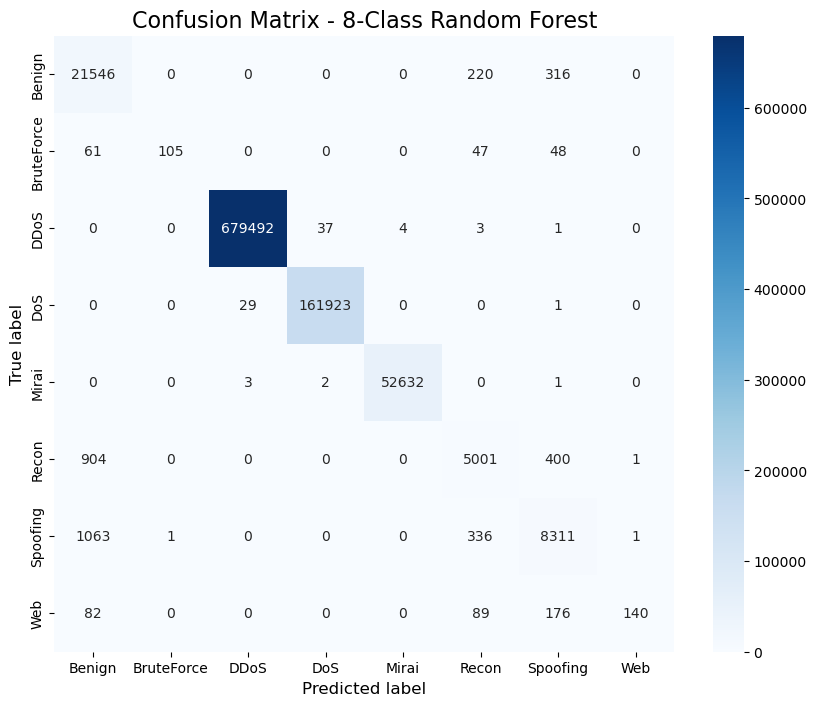


Top 20 important features:
1. IAT: 0.4965
2. Min: 0.0475
3. flow_duration: 0.0426
4. Magnitue: 0.0374
5. AVG: 0.0369
6. Protocol Type: 0.0335
7. Max: 0.0312
8. Header_Length: 0.0311
9. Tot sum: 0.0287
10. Tot size: 0.0250
11. rst_count: 0.0200
12. urg_count: 0.0187
13. Srate: 0.0178
14. Rate: 0.0170
15. Number: 0.0132
16. Variance: 0.0118
17. Radius: 0.0111
18. Std: 0.0106
19. Weight: 0.0104
20. Covariance: 0.0096


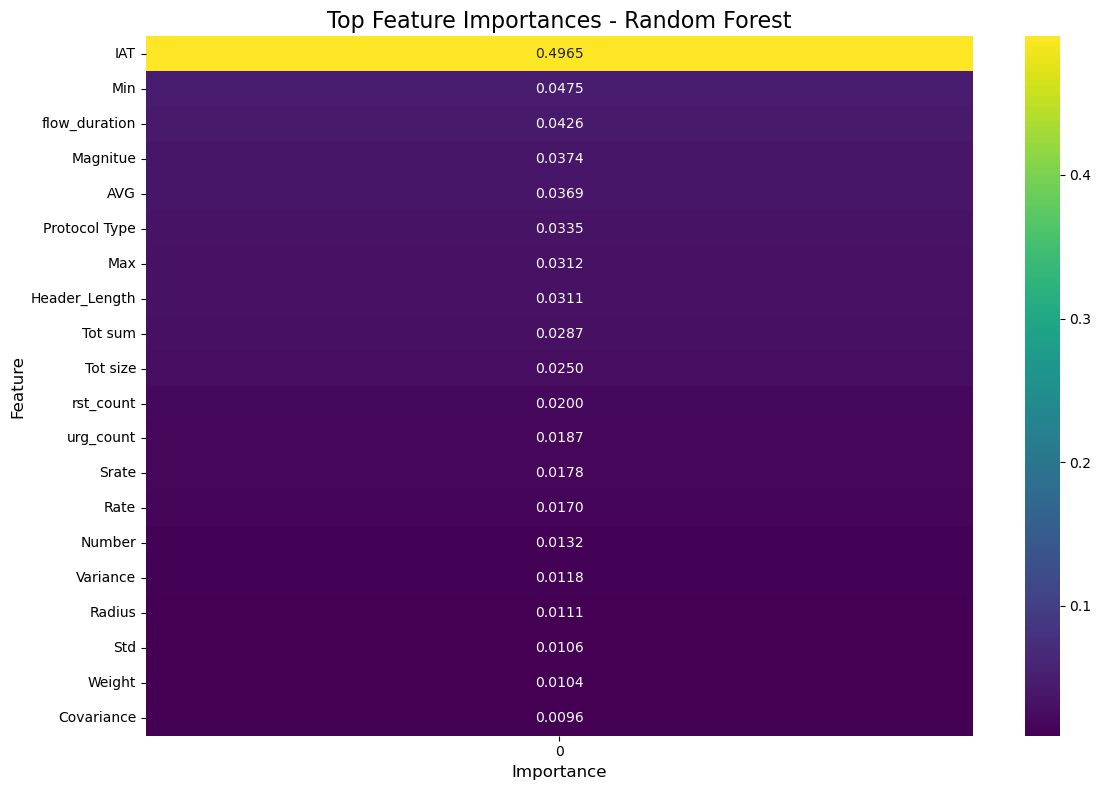

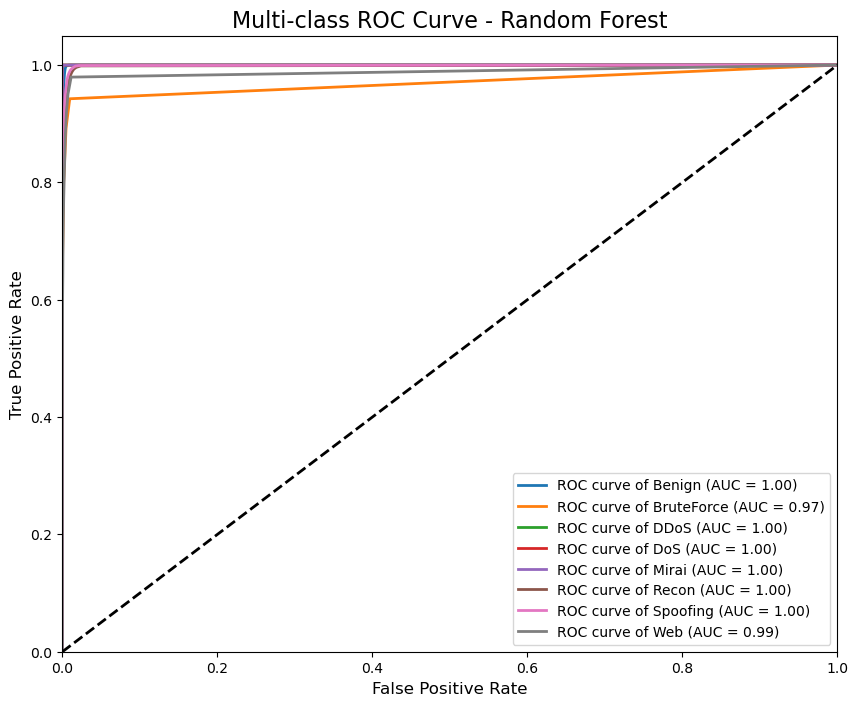



Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    recall_score, precision_score, log_loss, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42                       
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'  
SAMPLING_FRACTION = 0.1                 
TOP_N_FEATURES = 20                      

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# Step 1: Load CSV files and sample rows
print("\nStep 1: Loading CSV files with sampling to avoid memory issues...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))  # Get all CSV files in the folder
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)  
    df_list.append(df)

main_df = pd.concat(df_list, ignore_index=True)  # Combine all CSVs
main_df.dropna(axis=1, how='all', inplace=True)  # Drop empty columns
main_df.dropna(inplace=True)                      # Drop rows with missing values
main_df.drop_duplicates(inplace=True)            # Drop duplicate rows
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")

# Step 2: Map labels to 8 main categories
category_map = {
    "BenignTraffic": "Benign",
    "DDoS-ACK_Fragmentation": "DDoS", "DDoS-HTTP_Flood": "DDoS", "DDoS-ICMP_Flood": "DDoS",
    "DDoS-ICMP_Fragmentation": "DDoS", "DDoS-PSHACK_Flood": "DDoS", "DDoS-RSTFINFlood": "DDoS",
    "DDoS-SlowLoris": "DDoS", "DDoS-SYN_Flood": "DDoS", "DDoS-SynonymousIP_Flood": "DDoS",
    "DDoS-TCP_Flood": "DDoS", "DDoS-UDP_Flood": "DDoS", "DDoS-UDP_Fragmentation": "DDoS",
    "DoS-TCP_Flood": "DoS", "DoS-SYN_Flood": "DoS", "DoS-UDP_Flood": "DoS", "DoS-HTTP_Flood": "DoS",
    "Recon-PingSweep": "Recon", "Recon-OSScan": "Recon", "Recon-VulnerabilityScan": "Recon",
    "Recon-PortScan": "Recon", "Recon-HostDiscovery": "Recon",
    "SqlInjection": "Web", "CommandInjection": "Web", "Backdoor_Malware": "Web",
    "Uploading_Attack": "Web", "XSS": "Web", "BrowserHijacking": "Web",
    "DictionaryBruteForce": "BruteForce",
    "MITM-ArpSpoofing": "Spoofing", "DNS_Spoofing": "Spoofing",
    "Mirai-greip_flood": "Mirai", "Mirai-greeth_flood": "Mirai", "Mirai-udpplain": "Mirai"
}
main_df['label'] = main_df['label'].map(category_map)
main_df.dropna(subset=['label'], inplace=True)  # Drop rows with unmapped labels
print(f"Labels mapped. Unique classes: {main_df['label'].unique()}")


print("\n=== Class Distribution ===")
for label, count in main_df['label'].value_counts().items():
    print(f"{label}: {count}")

normal_count = main_df[main_df['label'] == 'Benign'].shape[0]
attack_count = main_df[main_df['label'] != 'Benign'].shape[0]
print(f"\nNormal (Benign): {normal_count}")
print(f"Total Attacks  : {attack_count}")

# Step 3: Prepare features and target
cols_to_drop = ['label', 'device', 'ts']  # Columns to exclude from features
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)  # Numeric features only
y = main_df['label']  # Target labels

le = LabelEncoder()
y_encoded = le.fit_transform(y)  

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Random Forest
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Step 5: Evaluate model
y_pred = rf_model.predict(X_test_scaled)

print("\n=== 8-Class Random Forest Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("F1-score :", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Calculate train & test accuracy
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Model Performance ===")
print(f"Train Accuracy : {train_acc:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")

# Step 6: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - 8-Class Random Forest')

# Step 7: Feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  
feature_names = X.columns

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Plot heatmap of top features
importance_df = pd.DataFrame([importances], columns=feature_names)
top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - Random Forest", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

# Step 8: Multi-class ROC (binarize labels)
y_test_bin = label_binarize(y_test, classes=rf_model.classes_)
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-class ROC Curve - Random Forest", fontsize=16)
plt.legend(loc="lower right")
plt.show()

print("\n\nAnalysis Complete.")


Shape of Normal (Benign) class: (25000, 47)
Shape of Attack classes: (175000, 47)

Shape of each class:
Spoofing: 25000 samples
Mirai: 25000 samples
Web: 25000 samples
DoS: 25000 samples
DDoS: 25000 samples
Recon: 25000 samples
BruteForce: 25000 samples
Benign: 25000 samples

Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.90      0.89      5000
  BruteForce       0.90      0.96      0.93      5000
        DDoS       1.00      1.00      1.00      5000
         DoS       1.00      1.00      1.00      5000
       Mirai       1.00      1.00      1.00      5000
       Recon       0.90      0.80      0.85      5000
    Spoofing       0.93      0.83      0.87      5000
         Web       0.84      0.94      0.89      5000

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000


Top 10 Most Important Features:
          Featur

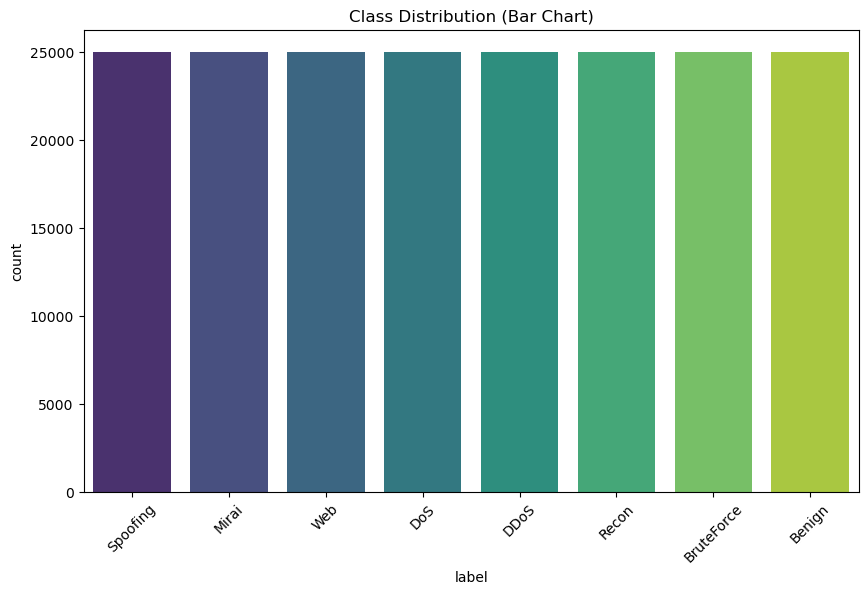

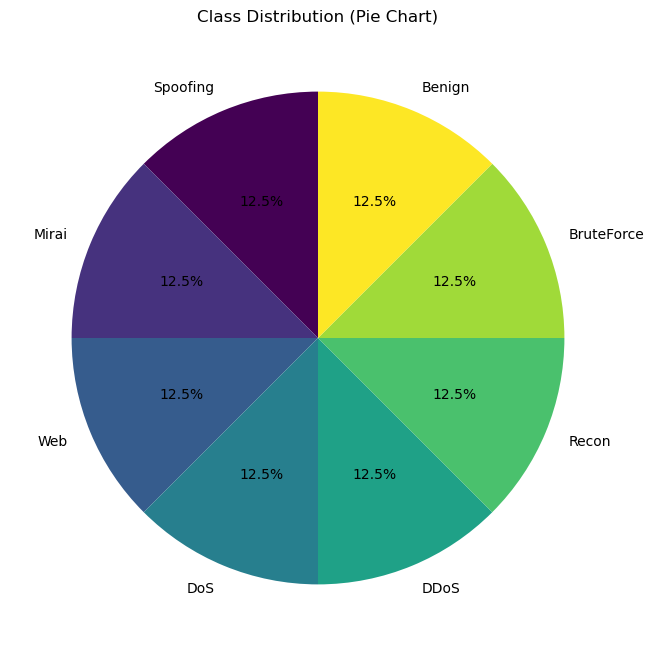

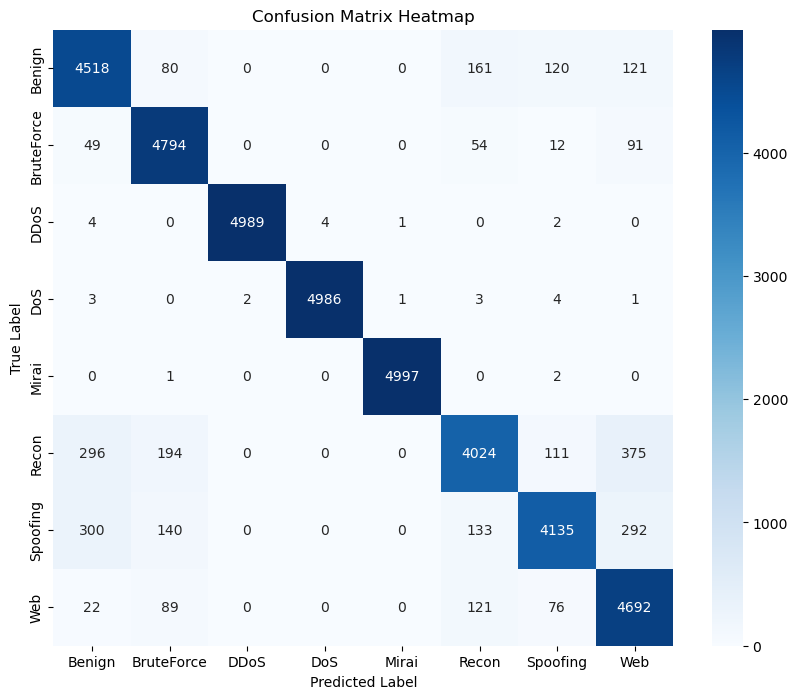

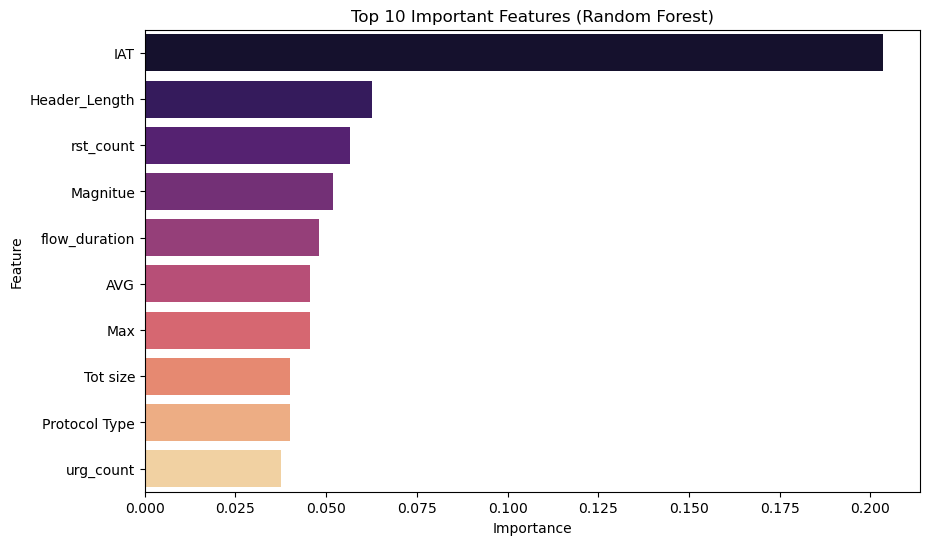

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load dataset
data = pd.read_csv('/Users/bodapati/Downloads/balanced_dataset.csv')

# Define features and target
features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
            'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
            'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
            'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
            'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
            'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']
target = 'label'

# Separate features and target
X = data[features]
y = data[target]

# Print shapes of normal and attack classes
normal_data = data[data['label'] == 'Be2nign']
attack_data = data[data['label'] != 'Benign']
print(f"Shape of Normal (Benign) class: {normal_data.shape}")
print(f"Shape of Attack classes: {attack_data.shape}")

# Print shape of individual classes
print("\nShape of each class:")
for label, count in data['label'].value_counts().items():
    print(f"{label}: {count} samples")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Handle missing values
X = X.fillna(X.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# ========================= PLOTS =========================

# 1. Class distribution bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Class Distribution (Bar Chart)")
plt.show()

# 2. Class distribution pie chart
plt.figure(figsize=(8, 8))
data['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap="viridis")
plt.title("Class Distribution (Pie Chart)")
plt.ylabel("")
plt.show()

# 3. Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

# 4. Top 10 feature importance bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10), palette="magma")
plt.title("Top 10 Important Features (Random Forest)")
plt.show()

Dataset Info:
Total samples: 200000

Class Distribution:
Spoofing: 25000 samples (12.5%)
Mirai: 25000 samples (12.5%)
Web: 25000 samples (12.5%)
DoS: 25000 samples (12.5%)
DDoS: 25000 samples (12.5%)
Recon: 25000 samples (12.5%)
BruteForce: 25000 samples (12.5%)
Benign: 25000 samples (12.5%)

Classification Report (Test Set):
              precision    recall  f1-score   support

      Benign       0.87      0.90      0.89      5000
  BruteForce       0.90      0.96      0.93      5000
        DDoS       1.00      1.00      1.00      5000
         DoS       1.00      1.00      1.00      5000
       Mirai       1.00      1.00      1.00      5000
       Recon       0.90      0.80      0.85      5000
    Spoofing       0.93      0.83      0.87      5000
         Web       0.84      0.94      0.89      5000

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000


K-Fold Cross-Validat

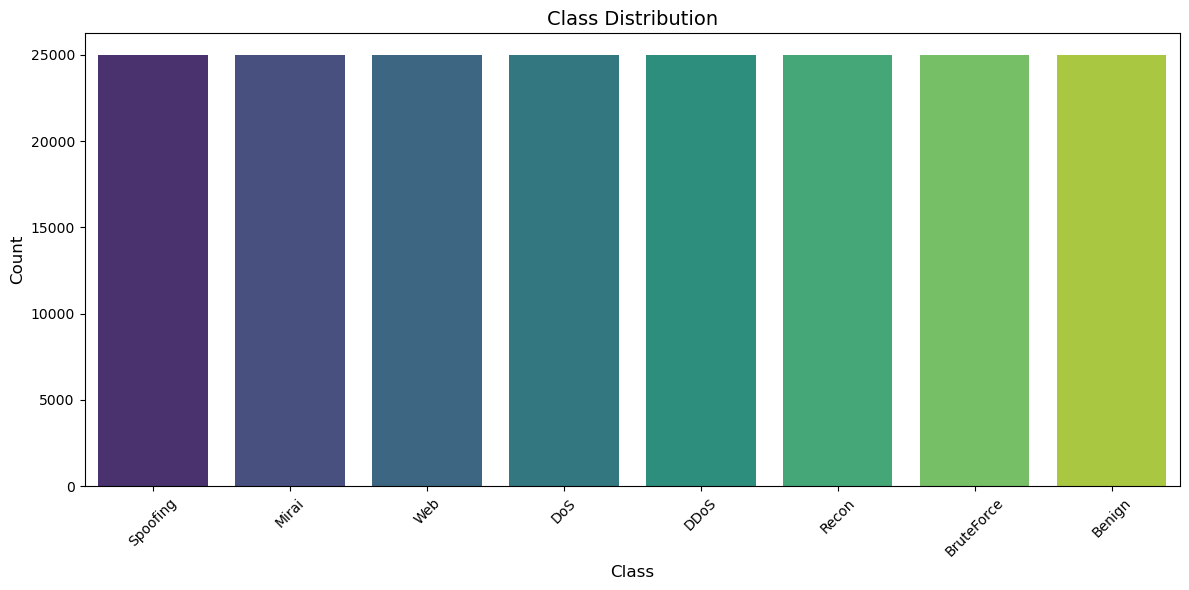

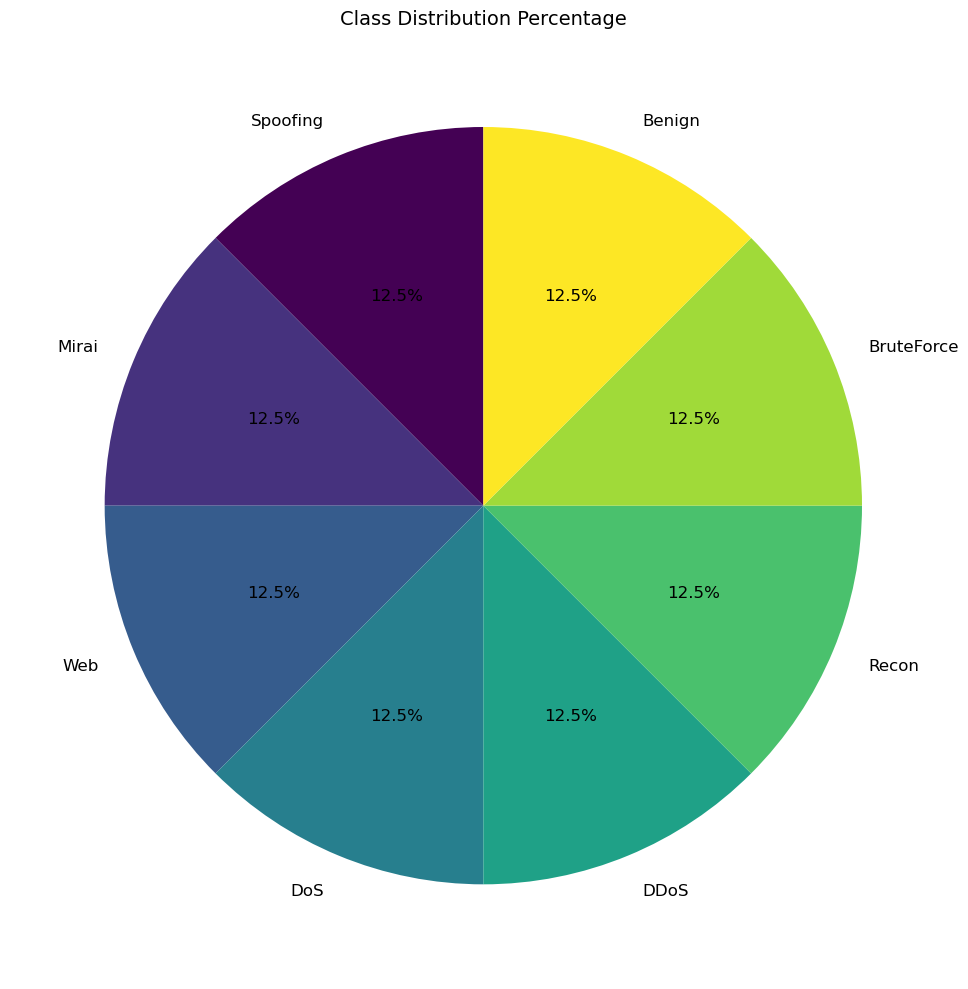

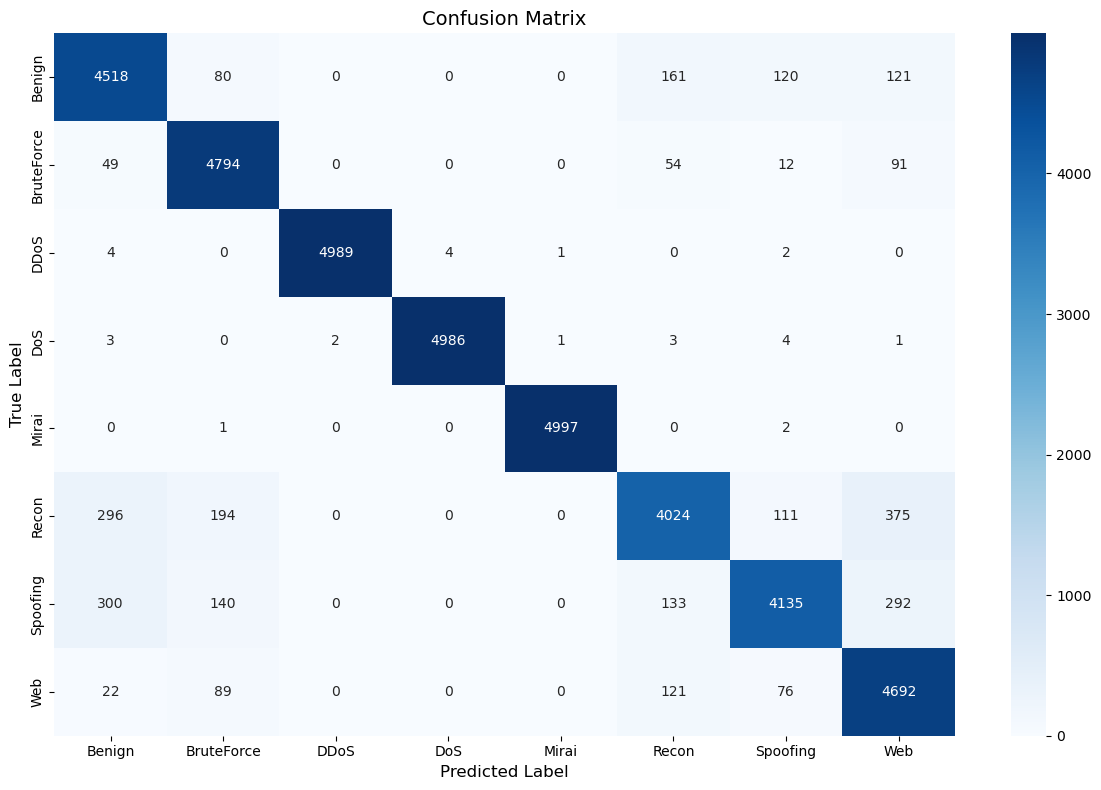

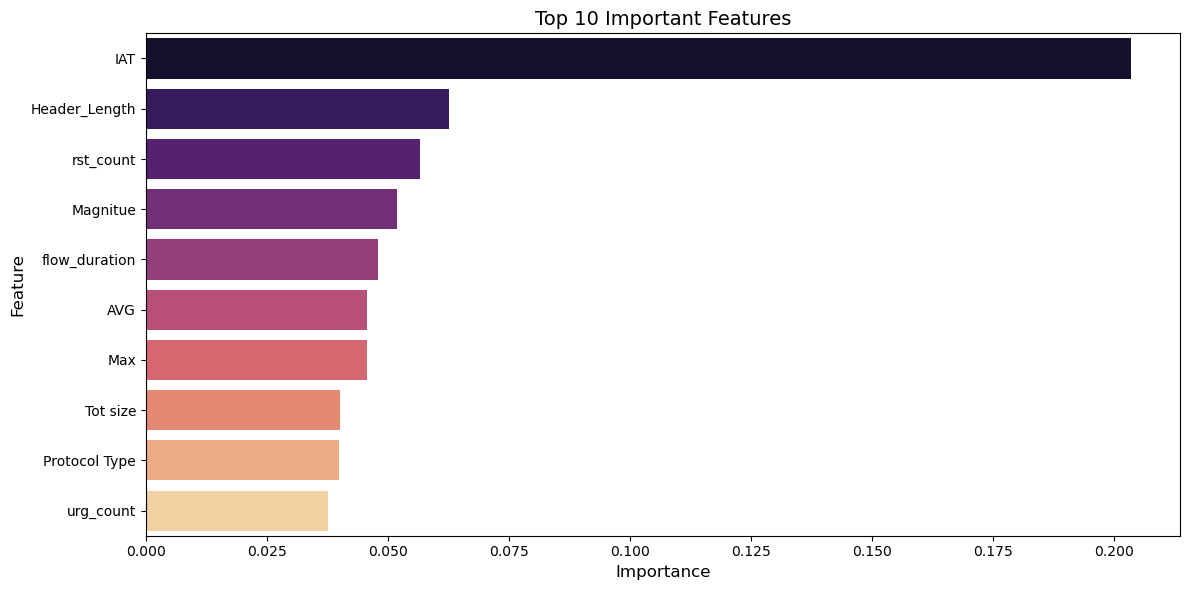

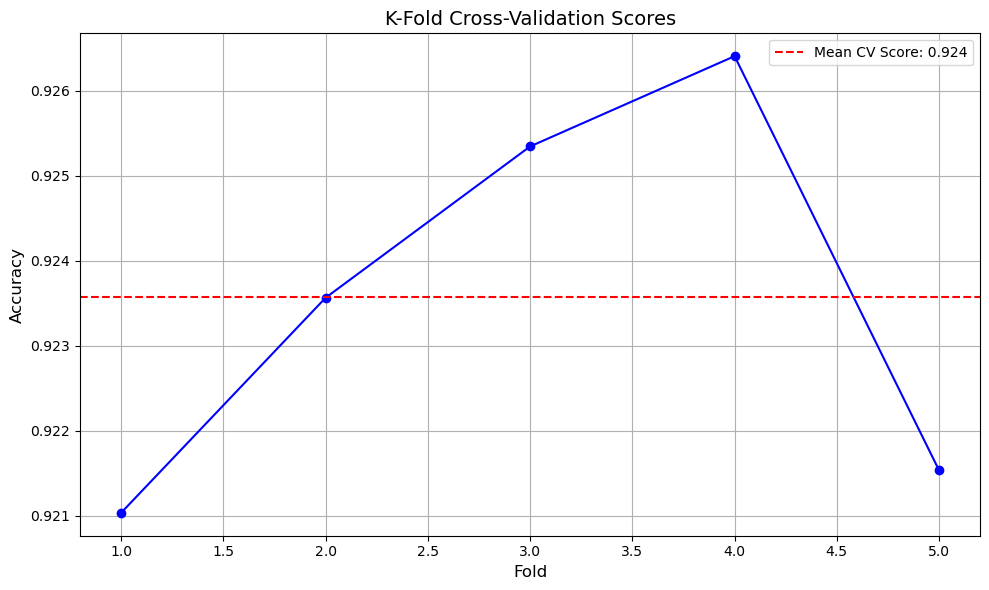

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
import os
from typing import Tuple, Dict
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def load_and_validate_data(file_path: str) -> pd.DataFrame:
    """
    Load and validate the dataset.
    
    Args:
        file_path (str): Path to the CSV file
        
    Returns:
        pd.DataFrame: Loaded dataset
    """
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at: {file_path}")
        data = pd.read_csv(file_path)
        if data.empty:
            raise ValueError("Dataset is empty")
        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def preprocess_data(data: pd.DataFrame, features: list, target: str) -> Tuple[pd.DataFrame, np.ndarray, LabelEncoder]:
    """
    Preprocess the data including handling missing values and encoding labels.
    
    Args:
        data (pd.DataFrame): Input dataset
        features (list): List of feature columns
        target (str): Target column name
        
    Returns:
        Tuple containing processed features, encoded labels, and label encoder
    """
    try:
        # Validate features and target
        missing_cols = [col for col in features + [target] if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")

        X = data[features]
        y = data[target]

        # Handle missing values
        X = X.fillna(X.mean())

        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        return X, y_encoded, label_encoder
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        raise

def train_and_evaluate_model(X: pd.DataFrame, y: np.ndarray, 
                           label_encoder: LabelEncoder, n_splits: int = 5) -> Dict:
    """
    Train and evaluate the Random Forest model with K-fold cross-validation.
    
    Args:
        X (pd.DataFrame): Features
        y (np.ndarray): Encoded labels
        label_encoder (LabelEncoder): Fitted label encoder
        n_splits (int): Number of folds for K-fold cross-validation
        
    Returns:
        Dict containing model, predictions, and metrics
    """
    try:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Initialize model
        model = RandomForestClassifier(
            n_estimators=100, 
            class_weight='balanced', 
            random_state=RANDOM_SEED, 
            n_jobs=-1
        )

        # K-fold cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
        cv_scores = []
        fold_results = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled, y_train), 1):
            X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Train model on fold
            model.fit(X_fold_train, y_fold_train)
            y_fold_pred = model.predict(X_fold_val)
            
            # Calculate fold score
            fold_score = model.score(X_fold_val, y_fold_val)
            cv_scores.append(fold_score)
            
            # Store fold results
            fold_results.append({
                'fold': fold,
                'score': fold_score,
                'classification_report': classification_report(
                    y_fold_val, 
                    y_fold_pred, 
                    target_names=label_encoder.classes_, 
                    output_dict=True
                )
            })

        # Train final model on full training data
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Calculate ROC curve for binary classification
        roc_data = None
        if len(label_encoder.classes_) == 2:
            y_score = model.predict_proba(X_test_scaled)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc_data = (fpr, tpr, roc_auc)

        return {
            'model': model,
            'y_pred': y_pred,
            'y_test': y_test,
            'X_test_scaled': X_test_scaled,
            'cv_scores': cv_scores,
            'fold_results': fold_results,
            'roc_data': roc_data,
            'label_encoder': label_encoder
        }
    except Exception as e:
        print(f"Error in model training/evaluation: {str(e)}")
        raise

def plot_results(data: pd.DataFrame, results: Dict, features: list):
    """
    Create visualizations for the analysis results.
    
    Args:
        data (pd.DataFrame): Original dataset
        results (Dict): Results from model training
        features (list): List of feature columns
    """
    try:
        # 1. Class distribution bar chart
        plt.figure(figsize=(12, 6))
        sns.countplot(x='label', data=data, order=data['label'].value_counts().index, 
                     palette="viridis")
        plt.xticks(rotation=45)
        plt.title("Class Distribution", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.tight_layout()
        plt.show()

        # 2. Class distribution pie chart
        plt.figure(figsize=(10, 10))
        data['label'].value_counts().plot.pie(
            autopct='%1.1f%%', 
            startangle=90, 
            cmap="viridis",
            textprops={'fontsize': 12}
        )
        plt.title("Class Distribution Percentage", fontsize=14)
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

        # 3. Confusion matrix heatmap
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=results['label_encoder'].classes_,
                   yticklabels=results['label_encoder'].classes_)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.ylabel("True Label", fontsize=12)
        plt.title("Confusion Matrix", fontsize=14)
        plt.tight_layout()
        plt.show()

        # 4. Feature importance
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': results['model'].feature_importances_
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10), 
                   palette="magma")
        plt.title("Top 10 Important Features", fontsize=14)
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.tight_layout()
        plt.show()

        # 5. ROC Curve (for binary classification)
        if results['roc_data']:
            fpr, tpr, roc_auc = results['roc_data']
            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()

        # 6. K-fold cross-validation scores
        mean_cv_score = np.mean(results['cv_scores'])
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(results['cv_scores']) + 1), results['cv_scores'], 
                marker='o', linestyle='-', color='b')
        plt.axhline(y=mean_cv_score, color='r', linestyle='--', 
                   label=f'Mean CV Score: {mean_cv_score:.3f}')
        plt.xlabel('Fold', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('K-Fold Cross-Validation Scores', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        raise

def main():
    # Define features and target
    features = [
        'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
        'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
        'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
        'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
        'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
        'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'
    ]
    target = 'label'
    
    # Load data
    file_path = '/Users/bodapati/Downloads/balanced_dataset.csv'
    data = load_and_validate_data(file_path)
    
    # Print dataset info
    print("Dataset Info:")
    print(f"Total samples: {len(data)}")
    print("\nClass Distribution:")
    for label, count in data['label'].value_counts().items():
        print(f"{label}: {count} samples ({count/len(data)*100:.1f}%)")
    
    # Preprocess data
    X, y_encoded, label_encoder = preprocess_data(data, features, target)
    
    # Train and evaluate model with K-fold
    results = train_and_evaluate_model(X, y_encoded, label_encoder, n_splits=5)
    
    # Print results
    print("\nClassification Report (Test Set):")
    print(classification_report(
        results['y_test'], 
        results['y_pred'], 
        target_names=label_encoder.classes_
    ))
    
    print("\nK-Fold Cross-Validation Results:")
    for result in results['fold_results']:
        print(f"\nFold {result['fold']}:")
        print(f"Accuracy: {result['score']:.3f}")
        print("Classification Report:")
        for label, metrics in result['classification_report'].items():
            if isinstance(metrics, dict):
                print(f"{label}:")
                print(f"  Precision: {metrics['precision']:.3f}")
                print(f"  Recall: {metrics['recall']:.3f}")
                print(f"  F1-score: {metrics['f1-score']:.3f}")

    print(f"\nMean CV Score: {np.mean(results['cv_scores']):.3f} (+/- {np.std(results['cv_scores']) * 2:.3f})")
    
    print("\nTop 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': results['model'].feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(feature_importance.head(10))
    
    # Plot results
    plot_results(data, results, features)

if __name__ == "__main__":
    main()


Dataset Info:
Total samples: 350000

Class Distribution:
Benign: 175000 samples (50.0%)
Mirai: 25000 samples (7.1%)
Recon: 25000 samples (7.1%)
Spoofing: 25000 samples (7.1%)
DoS: 25000 samples (7.1%)
DDoS: 25000 samples (7.1%)
Web: 25000 samples (7.1%)
BruteForce: 25000 samples (7.1%)
Epoch 1/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7096 - loss: 0.8410
Epoch 2/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7733 - loss: 0.6239
Epoch 3/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7813 - loss: 0.5980
Epoch 4/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7859 - loss: 0.5819
Epoch 5/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7890 - loss: 0.5719
Epoch 6/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7920 - loss: 0.5616
Epoch 7/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7950 - loss: 0.5602
Epoch 8/10
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7982 - loss: 0.5518
E

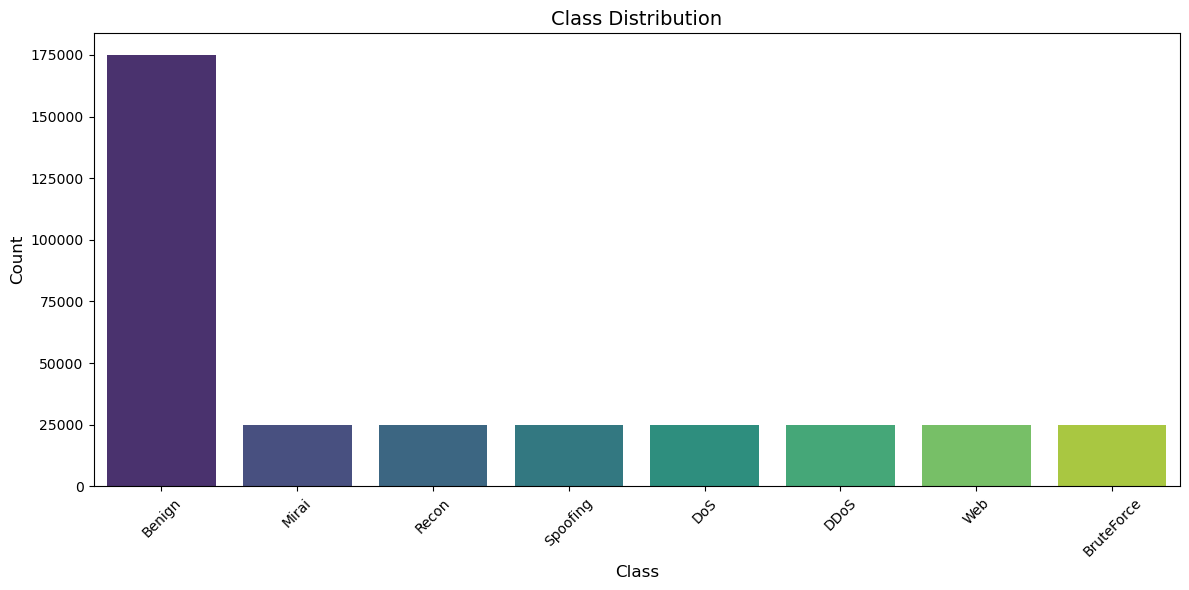

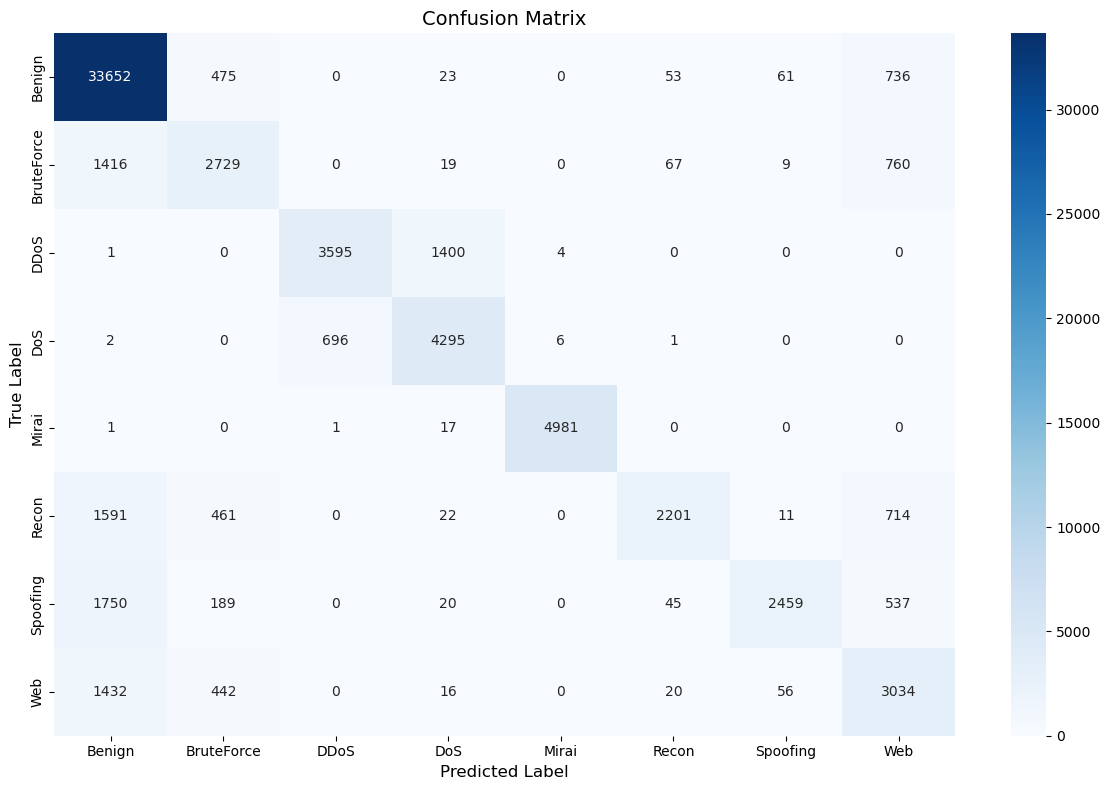

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
import os
from typing import Tuple, Dict
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def load_and_validate_data(file_path: str) -> pd.DataFrame:
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at: {file_path}")
        data = pd.read_csv(file_path)
        if data.empty:
            raise ValueError("Dataset is empty")
        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def preprocess_data(data: pd.DataFrame, features: list, target: str) -> Tuple[pd.DataFrame, np.ndarray, LabelEncoder]:
    try:
        missing_cols = [col for col in features + [target] if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")

        X = data[features]
        y = data[target]

        # Handle missing values
        X = X.fillna(X.mean())

        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)

        return X, y_encoded, label_encoder
    except Exception as e:
        print(f"Error in preprocessing: {str(e)}")
        raise

def create_cnn_model(input_shape: tuple, num_classes: int) -> Sequential:
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(X: pd.DataFrame, y: np.ndarray, 
                           label_encoder: LabelEncoder) -> Dict:
    try:
        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Reshape for CNN
        X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
        X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

        # Convert labels to one-hot
        num_classes = len(label_encoder.classes_)
        y_train_cat = to_categorical(y_train, num_classes)
        y_test_cat = to_categorical(y_test, num_classes)

        # Create and train model
        model = create_cnn_model((X_train_scaled.shape[1], 1), num_classes)
        model.fit(X_train_scaled, y_train_cat, epochs=10, batch_size=32, verbose=1)

        # Predictions
        y_pred = model.predict(X_test_scaled, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # ROC curve for binary classification
        roc_data = None
        if num_classes == 2:
            y_score = y_pred[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc_data = (fpr, tpr, roc_auc)

        return {
            'model': model,
            'y_pred': y_pred_classes,
            'y_test': y_test,
            'X_test_scaled': X_test_scaled,
            'roc_data': roc_data,
            'label_encoder': label_encoder
        }
    except Exception as e:
        print(f"Error in model training/evaluation: {str(e)}")
        raise

def plot_results(data: pd.DataFrame, results: Dict, features: list):
    try:
        # 1. Class distribution bar chart
        plt.figure(figsize=(12, 6))
        sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette="viridis")
        plt.xticks(rotation=45)
        plt.title("Class Distribution", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.tight_layout()
        plt.show()

        # 2. Confusion matrix
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                   xticklabels=results['label_encoder'].classes_,
                   yticklabels=results['label_encoder'].classes_)
        plt.xlabel("Predicted Label", fontsize=12)
        plt.ylabel("True Label", fontsize=12)
        plt.title("Confusion Matrix", fontsize=14)
        plt.tight_layout()
        plt.show()

        # 3. ROC Curve (binary only)
        if results['roc_data']:
            fpr, tpr, roc_auc = results['roc_data']
            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=12)
            plt.ylabel('True Positive Rate', fontsize=12)
            plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        raise

def main():
    features = [
        'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
        'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
        'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
        'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
        'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
        'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'
    ]
    target = 'label'
    
    file_path = '/Users/bodapati/Downloads/balanced_dataset1.csv'
    data = load_and_validate_data(file_path)
    
    print("Dataset Info:")
    print(f"Total samples: {len(data)}")
    print("\nClass Distribution:")
    for label, count in data['label'].value_counts().items():
        print(f"{label}: {count} samples ({count/len(data)*100:.1f}%)")
    
    X, y_encoded, label_encoder = preprocess_data(data, features, target)
    
    results = train_and_evaluate_model(X, y_encoded, label_encoder)
    
    print("\nClassification Report (Test Set):")
    print(classification_report(results['y_test'], results['y_pred'], target_names=label_encoder.classes_))
    
    print("\nNote: Feature importance is not directly available for CNN models.")
    
    plot_results(data, results, features)

if __name__ == "__main__":
    main()

Dataset Info:
Samples: 350000
label
Benign        175000
Mirai          25000
Recon          25000
Spoofing       25000
DoS            25000
DDoS           25000
Web            25000
BruteForce     25000
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.98      0.96     35000
  BruteForce       0.87      0.83      0.85      5000
        DDoS       1.00      1.00      1.00      5000
         DoS       1.00      1.00      1.00      5000
       Mirai       1.00      1.00      1.00      5000
       Recon       0.94      0.74      0.83      5000
    Spoofing       0.97      0.77      0.86      5000
         Web       0.80      0.86      0.83      5000

    accuracy                           0.94     70000
   macro avg       0.94      0.90      0.92     70000
weighted avg       0.94      0.94      0.93     70000



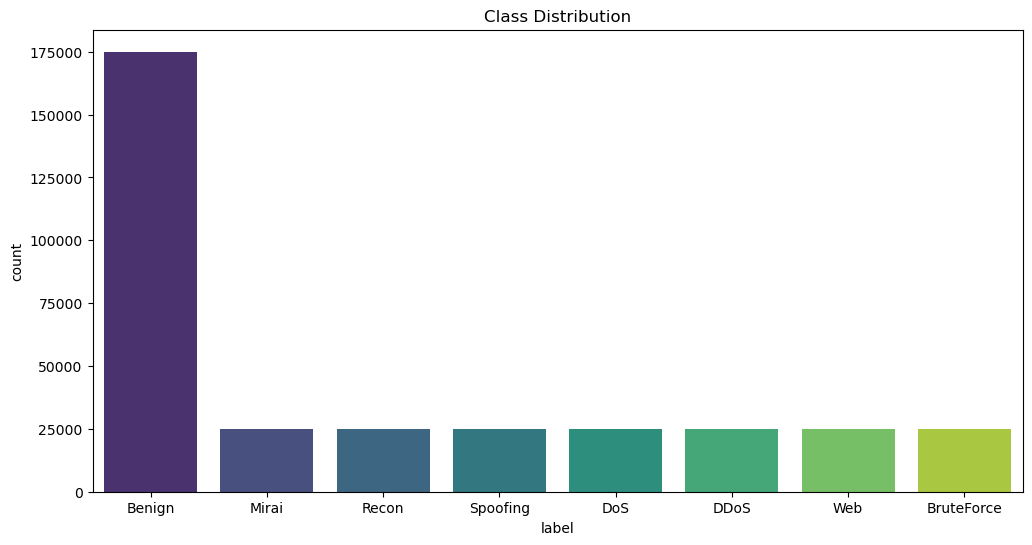

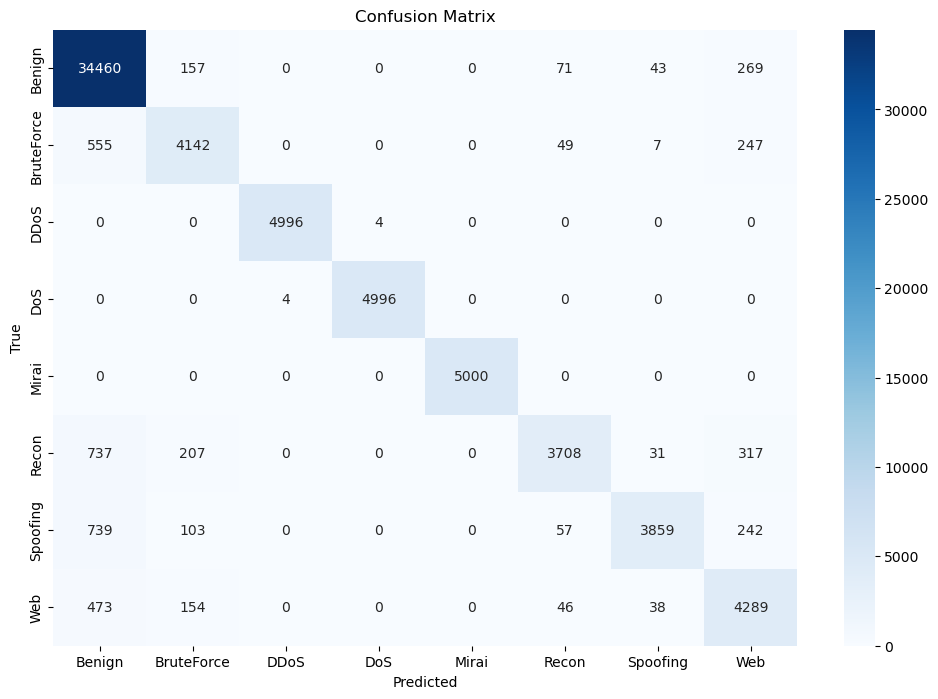

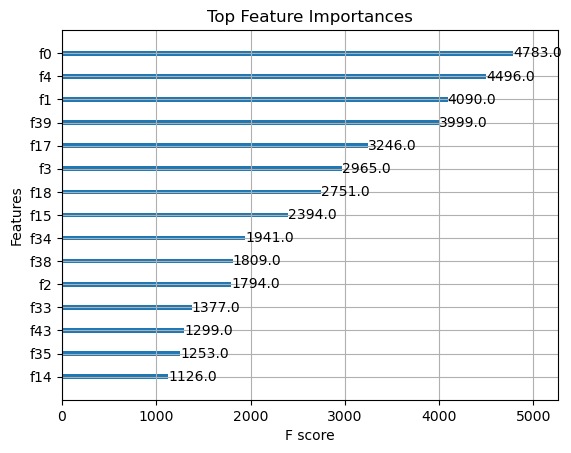

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def load_and_validate_data(file_path: str) -> pd.DataFrame:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset not found at: {file_path}")
    data = pd.read_csv(file_path)
    if data.empty:
        raise ValueError("Dataset is empty")
    return data

def preprocess_data(data: pd.DataFrame, features: list, target: str):
    missing_cols = [col for col in features + [target] if col not in data.columns]
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    X = data[features]
    y = data[target]

    # Handle missing values
    X = X.fillna(X.mean())

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Scale features (optional for XGBoost but improves performance sometimes)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y_encoded, label_encoder

def train_and_evaluate_xgb(X, y, label_encoder):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
    )

    # Define model
    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # ROC curve (binary only)
    roc_data = None
    if len(label_encoder.classes_) == 2:
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        roc_data = (fpr, tpr, roc_auc)

    return {
        "model": model,
        "y_test": y_test,
        "y_pred": y_pred,
        "roc_data": roc_data,
        "label_encoder": label_encoder,
        "X_test": X_test
    }

def plot_results(data, results, features):
    # Class distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x="label", data=data, order=data["label"].value_counts().index, palette="viridis")
    plt.title("Class Distribution")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(results["y_test"], results["y_pred"])
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=results["label_encoder"].classes_,
                yticklabels=results["label_encoder"].classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve (if binary)
    if results["roc_data"]:
        fpr, tpr, roc_auc = results["roc_data"]
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()

    # Feature importance
    xgb.plot_importance(results["model"], importance_type="weight", max_num_features=15)
    plt.title("Top Feature Importances")
    plt.show()

def main():
    # Features
    features = [
        'flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
        'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
        'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count',
        'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP',
        'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
        'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'
    ]
    target = "label"

    # Load data
    file_path = "/Users/bodapati/Downloads/balanced_dataset1.csv"
    data = load_and_validate_data(file_path)

    print("Dataset Info:")
    print(f"Samples: {len(data)}")
    print(data["label"].value_counts())

    # Preprocess
    X, y_encoded, label_encoder = preprocess_data(data, features, target)

    # Train and evaluate
    results = train_and_evaluate_xgb(X, y_encoded, label_encoder)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(results["y_test"], results["y_pred"], target_names=label_encoder.classes_))

    # Plots
    plot_results(data, results, features)

if __name__ == "__main__":
    main()